In [1]:
# This is a copy of geospatial there are likely some forgoten hold overs. Ima try and fix those.
# Otherwise this is intended to be a nashville bar crawl planner.
# I'm trying to get the geojson's for beer permints and pavement to find good walkable bar areas
#from shapely.geometry import Point
import pandas as pd
# !pip install geopandas
# !pip install contextily
import contextily as ctx

import geopandas as gpd
import matplotlib.pyplot as plt
# !pip install folium

import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

Read in the dat for pavement and places with beer licenses 
and look at one


In [3]:
import geopandas as gpd

pavement = gpd.read_file('C:\\Users\\Brian\\OneDrive\\Desktop\\DA12\\projects\\Python\\geospatial-python-da12-GartonBrian\\data\\Pavement_view_2034636516831235407.geojson')
beerlocals = gpd.read_file('C:\\Users\\Brian\\OneDrive\\Desktop\\DA12\\projects\\Python\\geospatial-python-da12-GartonBrian\\data\\Beer_Permit_Locations_Feature_Layer_view_5878506617859794089.geojson')

pavement.head()


,OBJECTID,PavementType,GlobalID,geometry
0,1,Paved Roadway,22fe905b-a97f-4b75-a339-428e76a5c700,"POLYGON ((-86.75637 36.24436, -86.75642 36.244..."
1,2,Paved Parking,b157c73c-7a2b-455f-80d9-ccf5c0589309,"POLYGON ((-86.72197 36.07002, -86.72184 36.069..."
2,3,Paved Roadway,bdf7c43e-46fb-49a9-94be-b83605a7e290,"POLYGON ((-86.82004 36.13314, -86.82004 36.133..."
3,4,Bridge,419d6760-2df0-435a-b698-cecc3cbb05b5,"POLYGON ((-86.82605 36.12871, -86.82606 36.128..."
4,5,Paved Roadway,e14cc8a4-d1ff-4405-87d4-2e96890fc8ac,"POLYGON ((-86.82704 36.12876, -86.82701 36.128..."


l;

In [5]:
beerlocals.head()

,ObjectId,Permit__,Status,Permit_Type,Permit_Sub_Type,Permit_Subtype_Description,Date_Entered,Date_Issued,Parcel,Business_Name,Business_Owner,Address,City,State,ZIP,Council_Dist,Census_Tract,Lon,Lat,geometry
0,1,22-28079,ISSUED,BBPERMIT,ONOFFSALES,BB - On & Off Site Sales,"Thu, 22 Dec 2022 06:00:00 GMT","Fri, 10 Feb 2023 06:00:00 GMT",09212047000,RESIDENCE INN & SPRINGHILL SUITES NASHVILLE WE...,None,1801 HAYES ST,NASHVILLE,TN,37203,19,37019500,-86.796861,36.153709,POINT (-86.79686 36.15371)
1,2,22-28080,ISSUED,BBPERMIT,ONOFFSALES,BB - On & Off Site Sales,"Thu, 22 Dec 2022 06:00:00 GMT","Thu, 23 Feb 2023 06:00:00 GMT",09302000600,TOWNEPLACE SUITES NASHVILLE DOWNTOWN,None,310 GAY ST,NASHVILLE,TN,37201,19,37019500,-86.781481,36.168913,POINT (-86.78148 36.16891)
2,3,22-28084,ISSUED,BBPERMIT,ONSALES,BB - On Site Sales,"Tue, 27 Dec 2022 06:00:00 GMT","Thu, 09 Feb 2023 06:00:00 GMT",09216019200,VELVET TACO NASHVILLE MIDTOWN,None,1911 BROADWAY,NASHVILLE,TN,37203,19,37019500,-86.797192,36.150071,POINT (-86.79719 36.15007)
3,4,23-28088,ISSUED,BBPERMIT,OFFSALES,BB - Off Site Sales,"Tue, 03 Jan 2023 06:00:00 GMT","Fri, 14 Apr 2023 05:00:00 GMT",11603010000,QUICK MART,HIRAL PATEL,4409 HARDING PIKE,NASHVILLE,TN,37205,24,37018000,-86.847021,36.124861,POINT (-86.84702 36.12486)
4,5,23-28089,ISSUED,BBPERMIT,ONOFFSALES,BB - On & Off Site Sales,"Wed, 04 Jan 2023 06:00:00 GMT","Fri, 24 Mar 2023 05:00:00 GMT",08209026800,TACO MAMACITA NASHVILLE,Michael Monen,1234 6TH AVE N,NASHVILLE,TN,37208,19,37019400,-86.789990,36.176199,POINT (-86.78999 36.1762)


Ok so we've got points for beer locaitons and poly gons for pavement. I need to 1 filter for walkable pavement and not just any pavement and i need to 2 change the beer locations into circles, representing reasonable walking radius from that beer location 3 merge those two tables and get areas where there is bar crawl teritory 

1filter for walkable pavement 

In [8]:
# what types of pavement are there. 
unique_values = pavement['PavementType'].unique()
print(unique_values)

# view pavement type 

['Paved Roadway' 'Paved Parking' 'Bridge' 'Slab' 'Paved Driveway'
 'Gravel Parking' 'Gravel Roadway' 'Gravel Driveway' 'Paved Other' None
 'Gravel Other' 'Gravel Railway' 'Sidewalk' 'Major Building' 'Trail'
 'Other' 'Paved Trail' 'Bike Lane']


Lets go with sidewalk, paved trail, slab? paved parking, paved driveway the others sound ambiguous or not good to walk on for a while in any varity of shoe.

     OBJECTID    PavementType                              GlobalID  \
18         19  Paved Driveway  21b45f7c-74d2-41f0-8f10-be960752c198   
35         36  Paved Driveway  38a6dbc8-9c8c-49f8-bfb9-951f0bc724d8   
56         58  Paved Driveway  720d404a-8793-4220-a5ca-a698cf7acdff   
65         67  Paved Driveway  15cee5eb-253c-445f-8684-29c7d1877160   
107       112  Paved Driveway  cf00133d-48dc-432a-b004-6f6222973b00   

                                              geometry  
18   POLYGON ((-86.78836 36.15691, -86.7882 36.1566...  
35   POLYGON ((-86.81977 36.11549, -86.81979 36.115...  
56   POLYGON ((-86.74651 36.37367, -86.74649 36.373...  
65   POLYGON ((-86.78186 36.2297, -86.78194 36.2297...  
107  POLYGON ((-86.86955 36.31602, -86.87017 36.316...  


<Axes: >

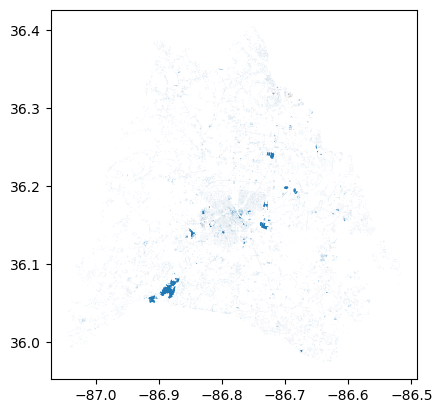

In [10]:
walkable_types = ['Sidewalk', 'Paved Trail', 'Paved Other', 'Bike Lane', 'Paved Driveway']
walkable_pavement = pavement[pavement['PavementType'].isin(walkable_types)]

print(walkable_pavement.head())
walkable_pavement.plot()

2 change beer locaitons to circles. google says to use buffers?

<Axes: >

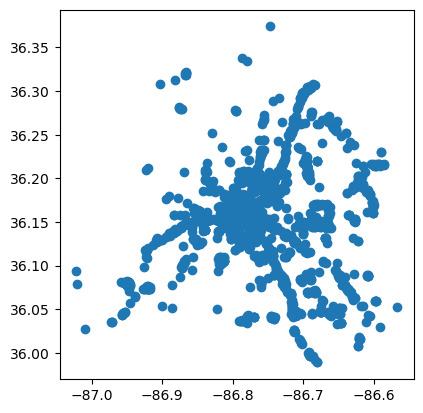

In [12]:
beerlocals.plot()

   ObjectId  Permit__  Status Permit_Type Permit_Sub_Type  \
0         1  22-28079  ISSUED    BBPERMIT      ONOFFSALES   
1         2  22-28080  ISSUED    BBPERMIT      ONOFFSALES   
2         3  22-28084  ISSUED    BBPERMIT         ONSALES   
3         4  23-28088  ISSUED    BBPERMIT        OFFSALES   
4         5  23-28089  ISSUED    BBPERMIT      ONOFFSALES   

  Permit_Subtype_Description                   Date_Entered  \
0   BB - On & Off Site Sales  Thu, 22 Dec 2022 06:00:00 GMT   
1   BB - On & Off Site Sales  Thu, 22 Dec 2022 06:00:00 GMT   
2         BB - On Site Sales  Tue, 27 Dec 2022 06:00:00 GMT   
3        BB - Off Site Sales  Tue, 03 Jan 2023 06:00:00 GMT   
4   BB - On & Off Site Sales  Wed, 04 Jan 2023 06:00:00 GMT   

                     Date_Issued       Parcel  \
0  Fri, 10 Feb 2023 06:00:00 GMT  09212047000   
1  Thu, 23 Feb 2023 06:00:00 GMT  09302000600   
2  Thu, 09 Feb 2023 06:00:00 GMT  09216019200   
3  Fri, 14 Apr 2023 05:00:00 GMT  11603010000   
4  Fri, 2

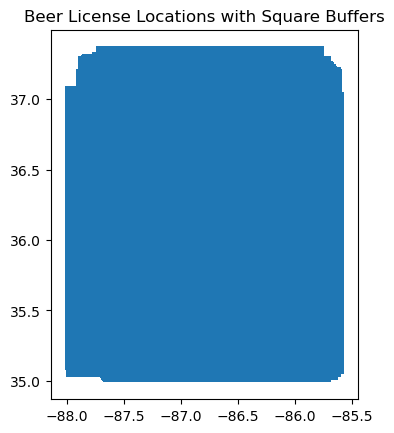

In [13]:
import geopandas as gpd
from shapely.geometry import Polygon

# assuming quarter mile is comfortable walking radius
half_side_length = 0.25

def create_square(point, half_side):
    # Calculate the four corners of the square
    x, y = point.x, point.y
    square_coords = [(x - half_side, y - half_side),
                     (x + half_side, y - half_side),
                     (x + half_side, y + half_side),
                     (x - half_side, y + half_side)]
    
    return Polygon(square_coords)

# Apply the function to create a square around each point
beerlocals['geometry'] = beerlocals['geometry'].apply(lambda point: create_square(point, half_side_length))

# Display the first few rows to verify
print(beerlocals.head())

# Plot the result
beerlocals.plot()
plt.title("Beer License Locations with Square Buffers")
plt.show()


ok merge the two maps and here we go!

In [14]:
import geopandas as gpd

# # Ensure both GeoDataFrames are using the same CRS
# beerlocals = beerlocals.to_crs(walkable_pavement.crs)

# Perform a spatial join to merge beer license locations with walkable pavement areas
merged = gpd.sjoin(beerlocals, walkable_pavement, how="inner", predicate="intersects")

# View the first few rows of the merged GeoDataFrame
print(merged.head())


MemoryError: Unable to allocate 7.29 GiB for an array with shape (15, 65247906) and data type object

Ok i'm pretty sure I can't merge these guys cause i don't have the memory. I don't have the memory cause I installed a bunch of things... I'm tired and i wanna go home.

3 mer two tables 


In [ ]:
print(pavement.loc[0, 'geometry'])

#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


#### zipcodes.plot();